# Levenberg-Marquardt algoritam

U ovoj svesci će biti implementiran pomenuti algoritam uz prateća teorijska objašnjenja.

## Uvod

Neka je dat skup od $m$ parova realnih brojeva $(x_1, y_1), (x_2, y_2), ..., (x_m, y_m)$ i funkcija $y = f(x, \mathbf{p})$ gde je $\mathbf{p} = (p_1, p_2, ..., p_n)$. Granični uslov je $m \geq n$. Cilj je pronaći $\mathbf{\hat{p}}$ za koji se dostiže minimum izraza $$S = \sum_{i=1}^{m}(y_i - f(x_i, \mathbf{\hat{p}})^2.$$

Uvešćemo $r_i = y - f(x_i, \mathbf{\hat{p}})$. Kako u definiciji funkcije figuriše $n$ nepoznatih, izjednačavanjem $\nabla S$ sa $0$, dobijamo $n$ jednačina oblika $$\frac{\partial S}{\partial p_j}=2\sum_{i}r_i \frac{\partial r_i}{\partial p_j}.$$

Kako su u pitanju potencijalno nelinearne funkcije, parcijalni izvodi $\frac{\partial r_i}{\partial p_j}$ ne moraju imati analitički oblik. Zato se ažuriranje parametara obavlja iterativno, po formuli $$\mathbf{\hat{p}}_{k + 1} = \mathbf{\hat{p}}_{k} + \Delta \mathbf{\hat{p}}.$$

Ovakvu formulaciju je neophodno linearizovati, pa se vrši Tejlorova aproksimacija u tački $\mathbf{\hat{p}}_{k} + \Delta \mathbf{\hat{p}}$ oko $\mathbf{\hat{p}}_{k}$: $$f(x_i, \mathbf{\hat{p}}_k + \Delta \mathbf{\hat{p}}) = f(x_i, \mathbf{\hat{p}}_k) + \sum_j\frac{\partial f(x_i, \mathbf{\hat{p}}_k)}{\partial p_j}\Delta \mathbf{\hat{p}} = f(x_i, \mathbf{\hat{p}}_k) + \sum_{j}J_{ij}\Delta\mathbf{\hat{p}},$$ pri čemu matricu $J$ zovemo Jakobijevom matricom. Primetimo da važi $\frac{\partial r_i}{\partial p_j} = -J_{ij}$. Ubacivanjem dobijenih identiteta u početne jednačine i sređivanjem izraza, dobijamo $$(J^{T}J)\mathbf{\hat{p}} = J^{T} \mathbf{\Delta y},$$ gde je sa $\mathbf{\Delta y}$ označen vektor svih $\Delta y_i = y_i - f(x_i, \mathbf{\hat{p}})$. Ovako opisani postupak se naziva Gauss-Newton algoritam.

Direktno rešavanje prethodnog identiteta bi dalo $\mathbf{\hat{p}} = (J^{T}J)^{-1}J^{T}\mathbf{\Delta y}$. Međutim, nije garantovano da je $J^TJ$ invertibilna matrica i u opštem slučaju neće ni biti. Kada se na to doda i potencijalno loša uslovljenost, jasno je da se nekako mora uvesti robusnost. To se postiže uvođenjem parametra $\lambda$, tako da dobijamo $$(J^{T}J + \lambda I)\mathbf{\hat{p}} = J^{T} \mathbf{\Delta y}.$$ Primetimo da parametrom $\lambda$, kojeg ćemo nazivati i LM parametrom, dobijamo balans između Gauss-Newton algoritma i standardnog gradijentnog spusta. U to se možemo uveriti stavljajući za LM parametar velike odnosno male vrednosti.

## Implementacija

In [41]:
%matplotlib inline

from collections import namedtuple
import logging
import time
from typing import Union, Tuple

import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from scipy.optimize import curve_fit
from sklearn.model_selection import ParameterGrid

CallableArg = Union[float, np.ndarray]
Result = namedtuple("Result", "error hyperparams params")
np_dtype = np.float32

In [42]:
def configure_logging(logging_level) -> logging.Logger:
    """Configures logging module."""
    logger = logging.getLogger("LM-log")
    logger.setLevel(logging_level)
    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(asctime)s.%(msecs)03d: [%(levelname)s] %(message)s")
    formatter.datefmt = "%y-%m-%d %H:%M:%S"
    formatter.converter = time.gmtime
    handler.setFormatter(formatter)
    logger.addHandler(handler)

    return logger

U narednoj ćeliji definisane su funkcije koje će kasnije biti aproksimirane.

In [43]:
def func_easy(x: CallableArg, a: float, b: float) -> CallableArg:
    """Function exp(ax + b).

    Called easy because it's expected to be fit easier.

    Args:
        x (CallableArg): input.
        a (float): function parameter.
        b (float): function parameter.

    Returns:
        out (CallableArg): output.
    """
    out = np.exp(a * x + b)

    return out


def func_hard(x: CallableArg, a: float, b: float):
    """Function exp(ax + b).

    Called hard because it's expected to be fit harder.

    Args:
        x (CallableArg): input.
        a (float): function parameter.
        b (float): function parameter.

    Returns:
        out (CallableArg): output.
    """
    out = a * np.cos(b * x) + b * np.sin(a * x)

    return out


U narednoj ćeliji je implementirano izračunavanje matrice parcijalnih izvoda prvog reda tj. Jakobijeve matrice. Ne koriste se nikakva eventualna svojstva funkcije, već se pomenuti izvodi računaju numerički.

In [44]:
def calc_jacobian(func, x: np.ndarray, params: np.ndarray, delta: float = 1e-8):
    """Calculates Jacobian matrix numerically in the given point.

    Args:
        func (Callable): calculates Jacobian for this function.
        x (np.ndarray): data points.
        params (np.ndarray): parameters to be updated.
        delta (float): difference value (i.e. dx).

    Returns:
        J (np.ndarray): Jacobian matrix.
    """
    m = x.shape[0]
    n = params.shape[0]

    J = np.zeros((m, n), dtype=np_dtype)
    for i in range(m):
        for j in range(n):
            delta_j = np.zeros_like(params)
            delta_j[j] = delta
            delta_params = params + delta_j

            # calculates [f(x + dx) - f(x)] / dx
            diff = func(x[i], *delta_params) - func(x[i], *params)
            J[i, j] = diff / delta

    return J

In [45]:
def calc_error(func, x: np.ndarray, y: np.ndarray, params: np.ndarray) -> float:
    """Calculates residuals for the given function and parameters.

    Args:
        func (Callable): function that fits the curve.
        x (np.ndarray): data points.
        y (np.ndarray): target values.
        params (np.ndarray): parameters to be updated.

    Returns:
        error (float): sum of squared residuals.
    """
    r = y - func(x, *params)
    error = np.sum(np.power(r, 2))

    return error

In [46]:
def run_single_iteration(func, x: np.ndarray, y: np.ndarray, params: np.ndarray, lmbd: float) -> Tuple[np.ndarray, float]:
    """Runs single-update iteration and calculates error.

    Args:
        x (np.ndarray): data points.
        y (np.ndarray): target values.
        params (np.ndarray): parameters to be updated.
        lmbd (float): LM parameter.

    Returns:
        params_upd, curr_error (tuple): updated parameters and error.
    """
    m = params.shape[0]

    # (J.T @ J + lmbd * I) @ params = J.T @ r
    J = calc_jacobian(func, x, params)
    A = J.T @ J + lmbd * np.eye(m)
    r = y - func(x, *params)
    b = J.T @ r

    params_delta = linalg.solve(A, b)
    params_upd = params + params_delta
    curr_error = calc_error(func, x, y, params_upd)

    return params_upd, curr_error


U narednoj ćeliji je implementiran Levenberg-Marquardt algoritam kojem se pored očiglednih argumenata prosleđuju i dodatni kojima se vrši ažuriranje LM parametra.

Da bi LM algoritam radio dovoljno robusno, neophodno je vršiti ažuriranje LM parametra pored ažuriranja parametara funkcije. Kako se kroz iteracije očekuje konvergencija, odnosno sve manja greška, koraci ažuriranja treba da budu manji da ne bi došlo do ispadanja iz lokalnog minimuma. Zato se nakon svake iteracije proverava kolika bi bila greška da se umesto $\lambda$ koristi $\lambda / \lambda_{↓}$, gde je $\lambda_{↓} > 1$. Ukoliko ni stara ni nova vrednost LM parametra ne dovode do poboljšanja, $\lambda$ se menja $\lambda \cdot \lambda_{↑}$ (takođe veći od $1$) sukcesivno dokle god se ili ne dođe do najveće dopustive vrednosti ili greška ne smanji. U suprotnom, bira se ona vrednost za $\lambda$ koja ima manju grešku.

In [47]:
def levenberg_marquardt(func, x: np.ndarray, y: np.ndarray, init_params: np.ndarray, init_lmbd: float,
                        logger: logging.Logger, num_iters: int = 100, lmbd_inc: float = 11, lmbd_dec: float = 9,
                        lmbd_cap: float = 1e7, error_tol: float = 1e-5) -> np.ndarray:
    params = np.copy(init_params)
    lmbd = init_lmbd

    num_iters_len = len(str(num_iters)) - 1
    for curr_iter in range(num_iters):
        params, curr_error = run_single_iteration(func, x, y, params, lmbd)
        logger.debug(f"Current iteration {curr_iter:>{num_iters_len}}: error={curr_error:.5f} lmbd={lmbd:.5f}")

        if curr_error < error_tol:
            logger.warning("Error is lower than the threshold. Early stopping engaged.")
            return params

        # updating lambda parameter as suggested in the (1)
        _, error_same_lmbd = run_single_iteration(func, x, y, params, lmbd)
        smaller_lmbd = lmbd / lmbd_dec
        _, error_smaller_lmbd = run_single_iteration(func, x, y, params, smaller_lmbd)
        if error_same_lmbd > curr_error and error_smaller_lmbd > curr_error:
            larger_lmbd = lmbd * lmbd_inc
            _, error_larger_lmbd = run_single_iteration(func, x, y, params, larger_lmbd)
            while error_larger_lmbd > curr_error and larger_lmbd < lmbd_cap:
                larger_lmbd = larger_lmbd * lmbd_inc
                _, error_larger_lmbd = run_single_iteration(func, x, y, params, larger_lmbd)

            lmbd = min(larger_lmbd, lmbd_cap)
        elif error_same_lmbd < curr_error and error_smaller_lmbd > curr_error:
            lmbd = lmbd
        elif error_same_lmbd > curr_error and error_smaller_lmbd < curr_error:
            lmbd = smaller_lmbd
        elif error_same_lmbd < error_smaller_lmbd:
            lmbd = lmbd
        else:
            lmbd = smaller_lmbd

    return params

In [48]:
plt.rcParams["figure.figsize"] = [12, 8]

logger = configure_logging(logging.INFO)
num_samples = 100

Umesto pokretanja algoritma za samo jednu konfiguraciju hiperparametara, isprobano je nekoliko različitih i odabrana je ona najbolja.

22-08-16 20:06:41.233: [INFO] scipy: [99.98361908 99.99172993]
22-08-16 20:06:41.233: [INFO] scipy: [99.98361908 99.99172993]
22-08-16 20:06:41.233: [INFO] scipy: [99.98361908 99.99172993]
22-08-16 20:06:41.233: [INFO] scipy: [99.98361908 99.99172993]
22-08-16 20:06:41.233: [INFO] scipy: [99.98361908 99.99172993]
22-08-16 20:06:41.240: [INFO] hyperparams: {'init_lmbd': 0.0001}
22-08-16 20:06:41.240: [INFO] hyperparams: {'init_lmbd': 0.0001}
22-08-16 20:06:41.240: [INFO] hyperparams: {'init_lmbd': 0.0001}
22-08-16 20:06:41.240: [INFO] hyperparams: {'init_lmbd': 0.0001}
22-08-16 20:06:41.240: [INFO] hyperparams: {'init_lmbd': 0.0001}
22-08-16 20:06:42.652: [INFO] hyperparams: {'init_lmbd': 0.025075}
22-08-16 20:06:42.652: [INFO] hyperparams: {'init_lmbd': 0.025075}
22-08-16 20:06:42.652: [INFO] hyperparams: {'init_lmbd': 0.025075}
22-08-16 20:06:42.652: [INFO] hyperparams: {'init_lmbd': 0.025075}
22-08-16 20:06:42.652: [INFO] hyperparams: {'init_lmbd': 0.025075}
22-08-16 20:06:44.059: [I

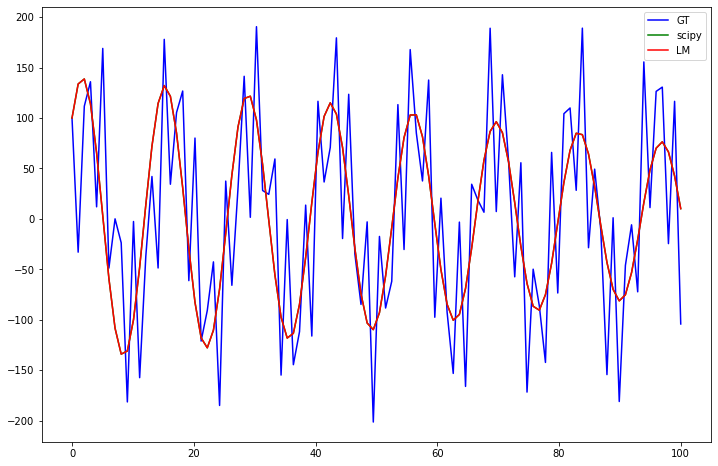

In [49]:
target = lambda x: 100 * np.cos(102 * x) + 102 * np.sin(100 * x)
x = np.linspace(0, 100, num_samples)
y = target(x)
init_params = np.array([100, 100], dtype=np_dtype)

plt.plot(x, y, color="blue", label="GT")

params_scipy = curve_fit(func_hard, x, y, init_params)[0]
logger.info(f"scipy: {params_scipy}")
plt.plot(x, func_hard(x, *params_scipy), color="green", label="scipy")

hyperparam_grid = ParameterGrid({"init_lmbd": np.linspace(1e-4, 1e-1, 5)})

results = []
for hyperparams in hyperparam_grid:
    logger.info(f"hyperparams: {hyperparams}")
    params = levenberg_marquardt(func_hard, x, y, init_params, logger=logger, **hyperparams)
    curr_error = calc_error(func_hard, x, y, params)
    results.append(Result(curr_error, hyperparams, params))

results = sorted(results, key=lambda res: res.error)
errors = list(map(lambda res: res.error, results))
logger.info(f"optimal hyperparams: {results[0].hyperparams}")

params_lm = results[0].params
logger.info(f"levenberg_marquardt: {params_lm}")
plt.plot(x, func_hard(x, *params_lm), color="red", label="LM")
plt.legend()

Na osnovu dobijenog grafika i optimalnih vrednosti parametara, možemo videti da greška aproksimacije ipak nije bliska nuli. To možemo pripisati osetljivosti algoritma na izbor početnih vrednosti parametara kao i na korak ažuriranja. Treba imati u vidu da da ne postoji samo jedan optimalan izbor parametara, budući da u definiciji funkcije figurišu $2\pi$ periodične funkcije.

22-08-16 20:06:48.437: [INFO] scipy: [0.3090497  0.41379493]
22-08-16 20:06:48.437: [INFO] scipy: [0.3090497  0.41379493]
22-08-16 20:06:48.437: [INFO] scipy: [0.3090497  0.41379493]
22-08-16 20:06:48.437: [INFO] scipy: [0.3090497  0.41379493]
22-08-16 20:06:48.437: [INFO] scipy: [0.3090497  0.41379493]
22-08-16 20:06:48.442: [INFO] hyperparams: {'init_lmbd': 0.0001}
22-08-16 20:06:48.442: [INFO] hyperparams: {'init_lmbd': 0.0001}
22-08-16 20:06:48.442: [INFO] hyperparams: {'init_lmbd': 0.0001}
22-08-16 20:06:48.442: [INFO] hyperparams: {'init_lmbd': 0.0001}
22-08-16 20:06:48.442: [INFO] hyperparams: {'init_lmbd': 0.0001}
22-08-16 20:06:49.248: [INFO] hyperparams: {'init_lmbd': 0.025075}
22-08-16 20:06:49.248: [INFO] hyperparams: {'init_lmbd': 0.025075}
22-08-16 20:06:49.248: [INFO] hyperparams: {'init_lmbd': 0.025075}
22-08-16 20:06:49.248: [INFO] hyperparams: {'init_lmbd': 0.025075}
22-08-16 20:06:49.248: [INFO] hyperparams: {'init_lmbd': 0.025075}
22-08-16 20:06:50.130: [INFO] hyper

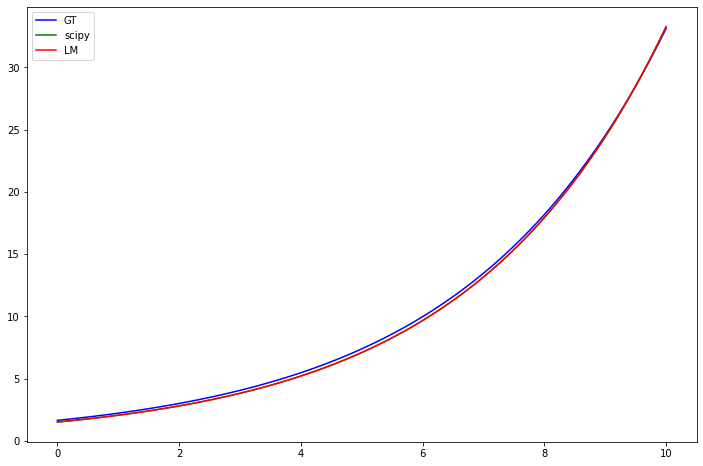

In [50]:
target = lambda x: np.exp(0.3 * x + 0.5)
x = np.linspace(0, 10, num_samples)
noise = np.random.randn(num_samples) * 1.5
y = target(x)
init_params = np.array([1, 1], dtype=np_dtype)

plt.plot(x, y, color="blue", label="GT")

params_scipy = curve_fit(func_easy, x, y + noise, init_params)[0]
logger.info(f"scipy: {params_scipy}")
plt.plot(x, func_easy(x, *params_scipy), color="green", label="scipy")

hyperparam_grid = ParameterGrid({"init_lmbd": np.linspace(1e-4, 1e-1, 5)})

results = []
for hyperparams in hyperparam_grid:
    logger.info(f"hyperparams: {hyperparams}")
    params = levenberg_marquardt(func_easy, x, y + noise, init_params, logger=logger, **hyperparams)
    curr_error = calc_error(func_easy, x, y + noise, params)
    results.append(Result(curr_error, hyperparams, params))

results = sorted(results, key=lambda res: res.error)
errors = list(map(lambda res: res.error, results))
logger.info(f"optimal hyperparams: {results[0].hyperparams}")

params_lm = results[0].params
logger.info(f"levenberg_marquardt: {params_lm}")
plt.plot(x, func_easy(x, *params_lm), color="red", label="LM")
plt.legend()

Na osnovu dobijenog grafika i optimalnih vrednosti parametara, možemo videti da je greška aproksimacije praktično nepostojeća iako je uveden određeni nivo šuma.

Takođe, možemo primetiti da gotovo ne postoji razlika između ručno implementiranog LM algoritma i onog iz poznatog modula `scipy`.